In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import pandas
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.manifold import TSNE

## **Pre-Proscessing Data**

In [3]:
def tokenize_code_line(line):
    
    line = re.sub(r'//.*', '', line)
    line = re.sub(r'/\*.*?\*/', '', line)
    
    tokens = re.findall(r'[A-Za-z_][A-Za-z0-9_]*|[{}()\[\];,.=<>!+\-*/&|^%#~?:]', line)
    return tokens

In [4]:
dataset_path = "linuxCode.txt"

vocab_counter = Counter()
all_tokens = []

with open(dataset_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        tokens = tokenize_code_line(line.strip())
        vocab_counter.update(tokens)
        all_tokens.extend(tokens)

print(f"Total tokens collected: {len(all_tokens)}")

Total tokens collected: 1314190


In [5]:
vocab = sorted(vocab_counter.keys())
vocab_size = len(vocab)

token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for token, idx in token_to_id.items()}

print(f"Vocabulary size: {vocab_size}")

print("\n10 most frequent tokens:")
print(vocab_counter.most_common(10))

print("\n10 least frequent tokens:")
print(vocab_counter.most_common()[-10:])

Vocabulary size: 35833

10 most frequent tokens:
[(')', 83714), ('(', 83598), (';', 77870), ('*', 72214), (',', 54287), ('-', 44389), ('=', 39595), ('>', 36911), ('.', 27385), ('}', 19182)]

10 least frequent tokens:
[('trace_user_enter', 1), ('OTOH', 1), ('vtime', 1), ('entrancy', 1), ('vtime_user_exit', 1), ('trace_user_exit', 1), ('CONTEXT_KERNEL', 1), ('TIF', 1), ('CONFIG_CONTEXT_TRACKING_FORCE', 1), ('context_tracking_init', 1)]


In [6]:
token_ids = torch.tensor([token_to_id[t] for t in all_tokens], dtype=torch.long)
print("Example encoded token IDs:", token_ids[:20])

Example encoded token IDs: tensor([   11,     6,     6, 20782,    11, 19806,    11, 18887,    11,  9937,
           10, 10903,     6,     6,  1724,     4,   883,     5,     8,     9])


In [7]:
context_window = 10
num_samples = len(token_ids) - context_window

X = torch.stack([token_ids[i:i+context_window] for i in range(num_samples)])
y = token_ids[context_window:]

In [8]:
pr = [id_to_token[x.item()] for x in X[0]]
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Sample X:", pr)
print("Sample y:", y[0], "->", id_to_token[y[0].item()])

X shape: torch.Size([1314180, 10])
y shape: torch.Size([1314180])
Sample X: ['/', '*', '*', 'linux', '/', 'kernel', '/', 'irq', '/', 'autoprobe']
Sample y: tensor(10) -> .


In [12]:
torch.save({
    "vocab": vocab,
    "token_to_id": token_to_id,
    "id_to_token": id_to_token,
    "X": X,
    "y": y
}, "data/kernel_dataset.pt")


print("Saved processed dataset to kernel_dataset.pt")

Saved processed dataset to kernel_dataset.pt


In [13]:
data = torch.load("data/kernel_dataset.pt")
vocab = data["vocab"]
X = data["X"]
y = data["y"]
token_to_id = data["token_to_id"]
id_to_token = data["id_to_token"]

vocab_size = len(vocab)
print(f"Loaded dataset — vocab size: {vocab_size}, X shape: {X.shape}")

Loaded dataset — vocab size: 35833, X shape: torch.Size([1314185, 5])


C:\Users\hemti\AppData\Local\Temp\ipykernel_19844\4211843429.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("data/kernel_dataset.pt")


In [14]:
dataset = TensorDataset(X, y)
batch_size = 4096

val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size) 

## **MLP architecture**

In [15]:
context_window = X.shape[1]
embedding_dim = 64
activation = "ReLU"

In [18]:
class MLPcodegen(nn.Module):
    def __init__(self,vocab_size, context_window=5, embedding_dim=64, hidden_size=512, activation="ReLU"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.fc1 = nn.Linear(context_window*embedding_dim,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.act = nn.ReLU() if activation.lower() == "ReLU" else nn.Tanh()
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(hidden_size,vocab_size)
    
    def forward(self,x):
        embeds = self.embedding(x)
        embeds = embeds.view(embeds.size(0),-1)
        hidden = self.drop(self.act(self.fc1(embeds)))
        hidden = self.drop(self.act(hidden))
        logits = self.out(hidden)
        return logits

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPcodegen(vocab_size,context_window,embedding_dim,activation=activation).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

## **Training**

In [ ]:
num_epochs = 8
train_losses, val_losses = [], []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct / total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    torch.save(model.state_dict(), f"models/model_category_2{context_window}{embedding_dim}_{activation}_state.pt")
print(f"model saved model_category_2{context_window}{embedding_dim}_{activation}_state.pt")

Epoch 1/8 | Train Loss: 4.7859 | Val Loss: 4.3864 | Val Acc: 0.4005
Epoch 2/8 | Train Loss: 4.2873 | Val Loss: 4.4632 | Val Acc: 0.4228
Epoch 3/8 | Train Loss: 4.0613 | Val Loss: 4.6044 | Val Acc: 0.4358
Epoch 4/8 | Train Loss: 3.9107 | Val Loss: 4.7598 | Val Acc: 0.4384
Epoch 5/8 | Train Loss: 3.7891 | Val Loss: 4.8652 | Val Acc: 0.4452
Epoch 6/8 | Train Loss: 3.7054 | Val Loss: 5.0208 | Val Acc: 0.4490
Epoch 7/8 | Train Loss: 3.6399 | Val Loss: 5.1583 | Val Acc: 0.4514
Epoch 8/8 | Train Loss: 3.6021 | Val Loss: 5.2777 | Val Acc: 0.4541
Model saved!


## **Model Evaluation**

In [21]:
model = MLPcodegen(vocab_size,context_window,embedding_dim)
model.load_state_dict(torch.load(f"model_category_2{context_window}{embedding_dim}_{activation}_state.pt"))
model.to(device)
model.eval()

C:\Users\hemti\AppData\Local\Temp\ipykernel_16152\303580632.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"model_category_2{context_w

MLPcodegen(
  (embedding): Embedding(35833, 32)
  (fc1): Linear(in_features=160, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (act): Tanh()
  (drop): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=512, out_features=35833, bias=True)
)

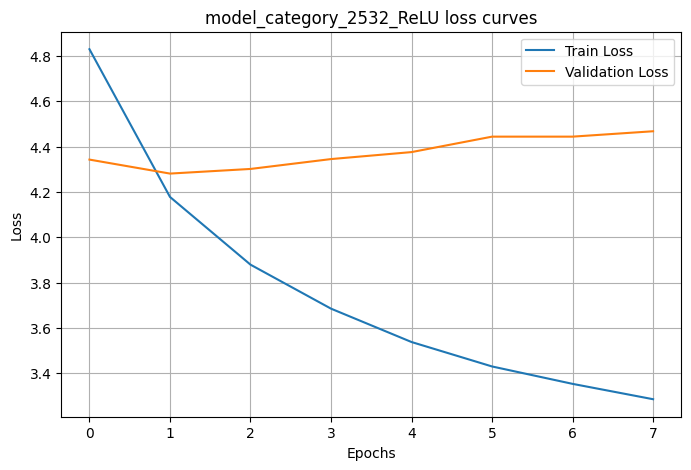

Final Validation Loss: 4.4681
Final Validation Accuracy: 43.99%


In [22]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"model_category_2{context_window}{embedding_dim}_{activation} loss curves")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.2f}%")


In [23]:
def generate_code(model, start_text, token_to_id, id_to_token, max_new_tokens=30, context_window=5, device="cuda"):
    model.eval()
    
    # Convert start text to tokens
    tokens = start_text.strip().split()
    context = [token_to_id.get(t, 0) for t in tokens]  # unknown tokens → 0
    
    generated = tokens.copy()
    
    for _ in range(max_new_tokens):
        # Take the last `context_window` tokens
        x = context[-context_window:]
        if len(x) < context_window:
            x = [0] * (context_window - len(x)) + x  # pad left with zeros
        
        x = torch.tensor([x], dtype=torch.long).to(device)
        with torch.no_grad():
            logits = model(x)
            probs = torch.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs[0], num_samples=1).item()
        
        next_token = id_to_token[next_id]
        generated.append(next_token)
        context.append(next_id)
    
    return " ".join(generated)


In [28]:
prompt = "int main ( ) { if ( start = = false ) {"
generated_text = generate_code(model, prompt, token_to_id, id_to_token, max_new_tokens=40, context_window=5, device=device)
print("Generated code:\n")
print(generated_text)

Generated code:

int main ( ) { if ( start = = false ) { / * * The RCU read a interrupt chain . n ) ; } static void ftrace_traceoff ( void ) ; # endif static int major ; int comm [ ] = ; } } static void irqtime_account_idle_ticks ( struct


### Embedings

In [26]:
embeddings = model.embedding.weight.detach().cpu().numpy()

tokens = ["int", "void", "return", "if", "else", "struct", "enum", "kmalloc", "kfree",
          "memcpy", "memset", "spin_lock", "spin_unlock", "mutex_lock", "mutex_unlock",
          "printk", "pr_info", "NULL", "dev", "probe", "init", "exit"]

tokens = [t for t in tokens if t in token_to_id]
ids = [token_to_id[t] for t in tokens]
selected_embeddings = embeddings[ids]

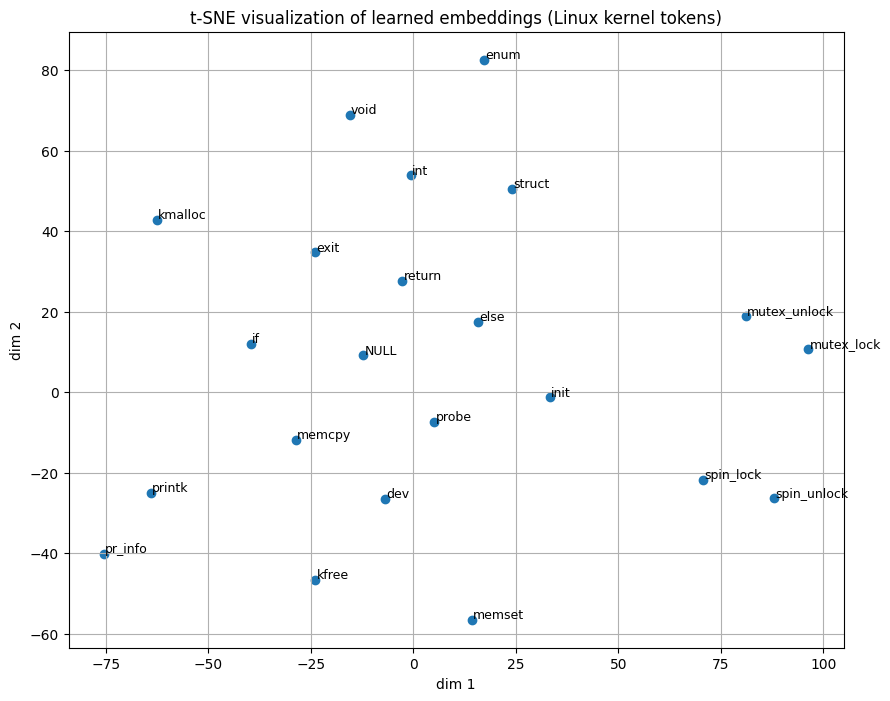

In [27]:
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
emb_2d = tsne.fit_transform(selected_embeddings)

plt.figure(figsize=(10,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1])

for i, t in enumerate(tokens):
    plt.text(emb_2d[i,0]+0.3, emb_2d[i,1]+0.3, t, fontsize=9)

plt.title("t-SNE visualization of learned embeddings (Linux kernel tokens)")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.grid(True)
plt.show()

In [28]:
import pickle

with open("stoi.pkl", "wb") as f:
    pickle.dump(token_to_id, f)

with open("itos.pkl", "wb") as f:
    pickle.dump(id_to_token, f)